In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from models import conditional_normal_model, marginal_normal_model
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from tqdm.notebook import tqdm

numpyro.set_host_device_count(8)
numpyro.enable_x64()
sns.set_theme('notebook', 'ticks', 'colorblind')

Let's build a reasonable LIGO-ish observational model.  We're gonna do BBH systems here (because why not).  So the true masses are distributed as a power law in $m_1$, power law in $q$ conditional on $m_1$, gaussian in $\chi_\mathrm{eff}$ with a small offset mean, and delta-function in $\delta \phi$.  The variable ordering is $\delta \phi$, $\chi_\mathrm{eff}$, $q$, $m_1$.

In [13]:
ndraw = 10000
nnormal = 2
ndim = 4

alpha_true = 2.35
beta_true = 1 # p(q) ~ q^beta => p(1/q) d(1/q) = p(q) dq => p(1/q) 1/q^2 dq = p(q) dq => p(1/q) = q^2 p(q) => p(1/q) = (1/q)^-(beta+2)
chi_mu = 0.1
chi_sigma = 0.15

delta_phis = np.zeros(ndraw)
chi_eff = np.random.normal(loc=chi_mu, scale=chi_sigma, size=ndraw)
q_invs = 1 + np.random.pareto(beta_true+1, size=ndraw)
qs = 1/q_invs
m1s = 1 + np.random.pareto(alpha_true-1, size=ndraw)

The observational model is a bit different, and meant to be evocative of the sorts of correlations among observed variables that occur in the pN expansion.  Let 
$$
M_c = m_1 \frac{q^{3/5}}{\left( 1 + q \right)^{1/5}}
$$
be the chirp mass.  Then let "observed" variables 
$$
x = \log M_c + \delta \phi
$$
$$
y = \log M_c + q
$$
$$
z = \log M_c - q
$$
and 
$$
w = (1 + q) \chi_\mathrm{eff}.
$$

Let the observational uncertainties be independent and Gaussian with 
$$
\sigma_{x,y,z,w} = \left[ 0.01, 0.1, 0.1, 0.1 \right].
$$

The code below implements this observational model, and produces posterior samples over $\delta \phi$, $\chi_\mathrm{eff}$, $q$, and $m_1$.

In [14]:
mcs = m1s * qs**(3/5) / (1+qs)**(1/5)
xts = np.log(mcs) + delta_phis
yts = np.log(mcs) + qs
zts = np.log(mcs) - qs
wts = (1 + qs)*chi_eff

xos = np.random.normal(loc=xts, scale=0.01)
yos = np.random.normal(loc=yts, scale=0.1)
zos = np.random.normal(loc=zts, scale=0.1)
wos = np.random.normal(loc=wts, scale=0.1)

In [33]:
y_sel_thresh = np.log(10/2**(1/5)) + 1

sel = yos > y_sel_thresh

nobs = 100
nsamp = 512

R_true = np.argmin(np.abs(np.cumsum(sel)-nobs))

dpsamps = []
cesamps = []
qsamps = []
m1samps = []
for i in tqdm(range(nobs)):
    xo = xos[sel][i]
    yo = yos[sel][i]
    zo = zos[sel][i]
    wo = wos[sel][i]

    xsamps = np.random.normal(loc=xo, scale=0.01, size=nsamp)
    ysamps = np.random.normal(loc=yo, scale=0.1, size=nsamp)
    zsamps = np.random.normal(loc=zo, scale=0.1, size=nsamp)
    wsamps = np.random.normal(loc=wo, scale=0.1, size=nsamp)

    mc = np.exp(0.5*(ysamps + zsamps))
    q = 0.5*(ysamps - zsamps)
    dp = xsamps - np.log(mc)
    ce = wsamps / (1 + q)
    m1 = mc / (q**(3/5)/(1+q)**(1/5))

    while np.any(q < 0) or np.any(q > 1) or np.any(m1 < 1):
        s = (q < 0) | (q > 1) | (m1 < 1)
        n = np.sum(s)

        xsamps = np.random.normal(loc=xo, scale=0.01, size=n)
        ysamps = np.random.normal(loc=yo, scale=0.1, size=n)
        zsamps = np.random.normal(loc=zo, scale=0.1, size=n)
        wsamps = np.random.normal(loc=wo, scale=0.1, size=n)

        mc[s] = np.exp(0.5*(ysamps + zsamps))
        q[s] = 0.5*(ysamps - zsamps)
        dp[s] = xsamps - np.log(mc[s])
        ce[s] = wsamps / (1 + q[s])
        m1[s] = mc[s] / (q[s]**(3/5) / (1 + q[s])**(1/5))
    dpsamps.append(dp)
    cesamps.append(ce)
    qsamps.append(q)
    m1samps.append(m1)

dpsamps = np.array(dpsamps)
cesamps = np.array(cesamps)
qsamps = np.array(qsamps)
m1samps = np.array(m1samps)

normal_wts = np.ones_like(m1samps)
other_wts = 2*(1+qsamps)/m1samps

samples = np.stack((dpsamps, cesamps, qsamps, m1samps), axis=2)

  0%|          | 0/100 [00:00<?, ?it/s]

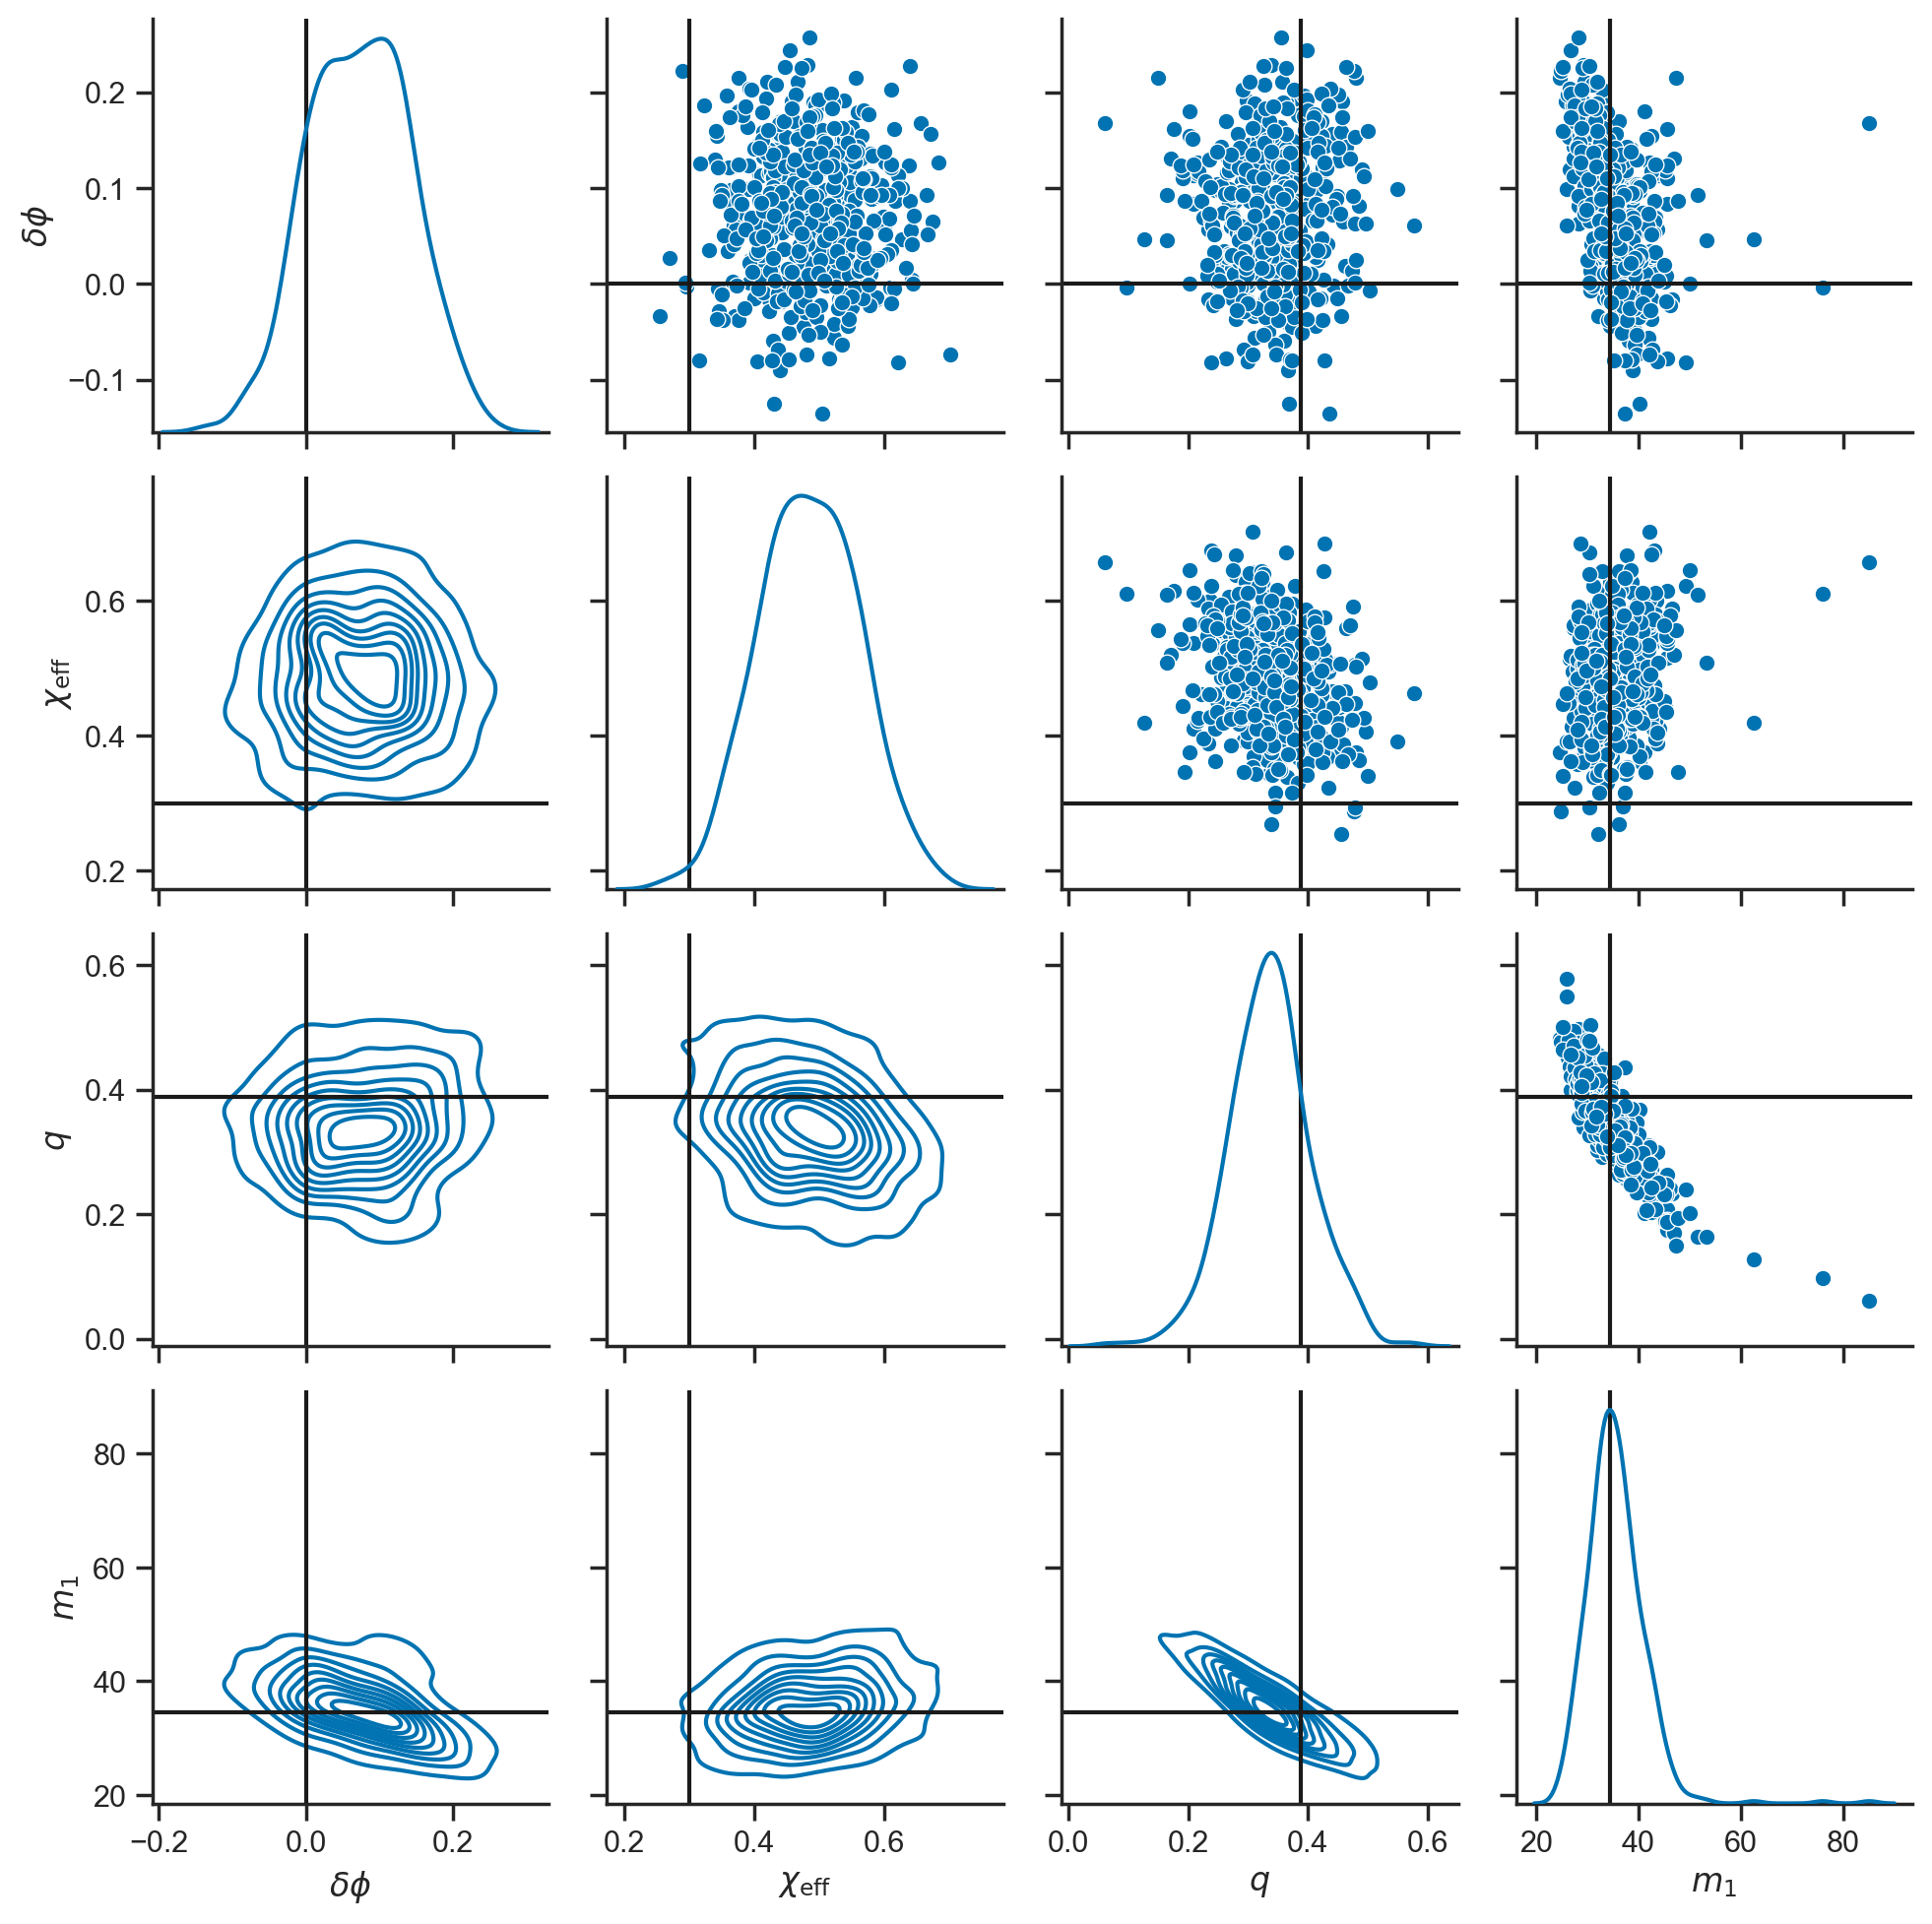

In [34]:
i = np.random.randint(nobs)
df = pd.DataFrame(data=samples[i,:,:], columns=[r'$\delta \phi$', r'$\chi_\mathrm{eff}$', r'$q$', r'$m_1$'])
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

t = [delta_phis[sel][i], chi_eff[sel][i], qs[sel][i], m1s[sel][i]]
for ii in range(4):
    for jj in range(4):
        if ii == jj:
            pg.axes[ii,jj].axvline(t[ii], color='k')
        else:
            pg.axes[ii,jj].axhline(t[ii], color='k')
            pg.axes[ii,jj].axvline(t[jj], color='k')

Draw some selection function samples:

In [35]:
ndraw_sel = 500000

delta_phis_sel = np.random.normal(loc=0, scale=0.1, size=ndraw_sel)
chi_eff_sel = np.random.normal(loc=chi_mu, scale=chi_sigma, size=ndraw_sel)
q_invs_sel = 1 + np.random.pareto(beta_true+1, size=ndraw_sel)
qs_sel = 1/q_invs_sel
m1s_sel = 1 + np.random.pareto(alpha_true-1, size=ndraw_sel)

mcs_sel = m1s_sel * qs_sel**(3/5) / (1+qs_sel)**(1/5)
xts_sel = np.log(mcs_sel) + delta_phis_sel
yts_sel = np.log(mcs_sel) + qs_sel
zts_sel = np.log(mcs_sel) - qs_sel
wts_sel = (1 + qs_sel)*chi_eff_sel

xos_sel = np.random.normal(loc=xts_sel, scale=0.01)
yos_sel = np.random.normal(loc=yts_sel, scale=0.1)
zos_sel = np.random.normal(loc=zts_sel, scale=0.1)
wos_sel = np.random.normal(loc=wts_sel, scale=0.1)

sel = yos_sel > y_sel_thresh
m1s_sel = m1s_sel[sel]
qs_sel = qs_sel[sel]
delta_phis_sel = delta_phis_sel[sel]
chi_eff_sel = chi_eff_sel[sel]

pdraw_sel = ss.norm(loc=0, scale=0.1).pdf(delta_phis_sel)*ss.norm(loc=chi_mu, scale=chi_sigma).pdf(chi_eff_sel)*ss.pareto(beta_true+1).pdf(1/qs_sel)/np.square(qs_sel)*ss.pareto(alpha_true-1).pdf(m1s_sel)
samples_sel = np.column_stack((delta_phis_sel, chi_eff_sel, qs_sel, m1s_sel))

In [36]:
def full_model(marginal_model, samples, prior_wts, n_normal, *args, predictive=False, **kwargs):
    alpha = numpyro.sample('alpha', dist.Uniform(1, 4))
    beta = numpyro.sample('beta', dist.Uniform(0, 4))

    def log_p_other(s):
        q = s[..., 0]
        m1 = s[..., 1]

        log_m1 = jnp.log(jnp.abs(m1))
        log_q = jnp.log(jnp.abs(q))

        log_smooth_m = jnp.where(m1 < 1, -0.5*jnp.square(log_m1/0.05), 0)

        return beta*log_q + jnp.log1p(beta) - alpha*log_m1 + jnp.log(alpha - 1) + log_smooth_m
    
    marginal_model(log_p_other, samples, prior_wts, n_normal, *args, predictive=predictive, **kwargs)

    if predictive:
        qinv = numpyro.sample('qinv', dist.Pareto(1, beta+1))
        q = numpyro.deterministic('q', 1/qinv)

        m1 = numpyro.sample('m1', dist.Pareto(1, alpha-1))

In [37]:
nmcmc = 1000
nchain = 4

marg_model = marginal_normal_model

kernel = NUTS(full_model, dense_mass=True)
mcmc = MCMC(kernel, num_warmup=nmcmc, num_samples=nmcmc, num_chains=nchain)
mcmc.run(jax.random.PRNGKey(np.random.randint(1<<32)), marg_model, samples, normal_wts*other_wts, nnormal, samples_sel=samples_sel, pdraw_sel=pdraw_sel, n_draw_sel=ndraw_sel)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [38]:
trace = az.from_numpyro(mcmc)

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'neff'}>,
        <Axes: title={'center': 'neff'}>],
       [<Axes: title={'center': 'neff_sel'}>,
        <Axes: title={'center': 'neff_sel'}>]], dtype=object)

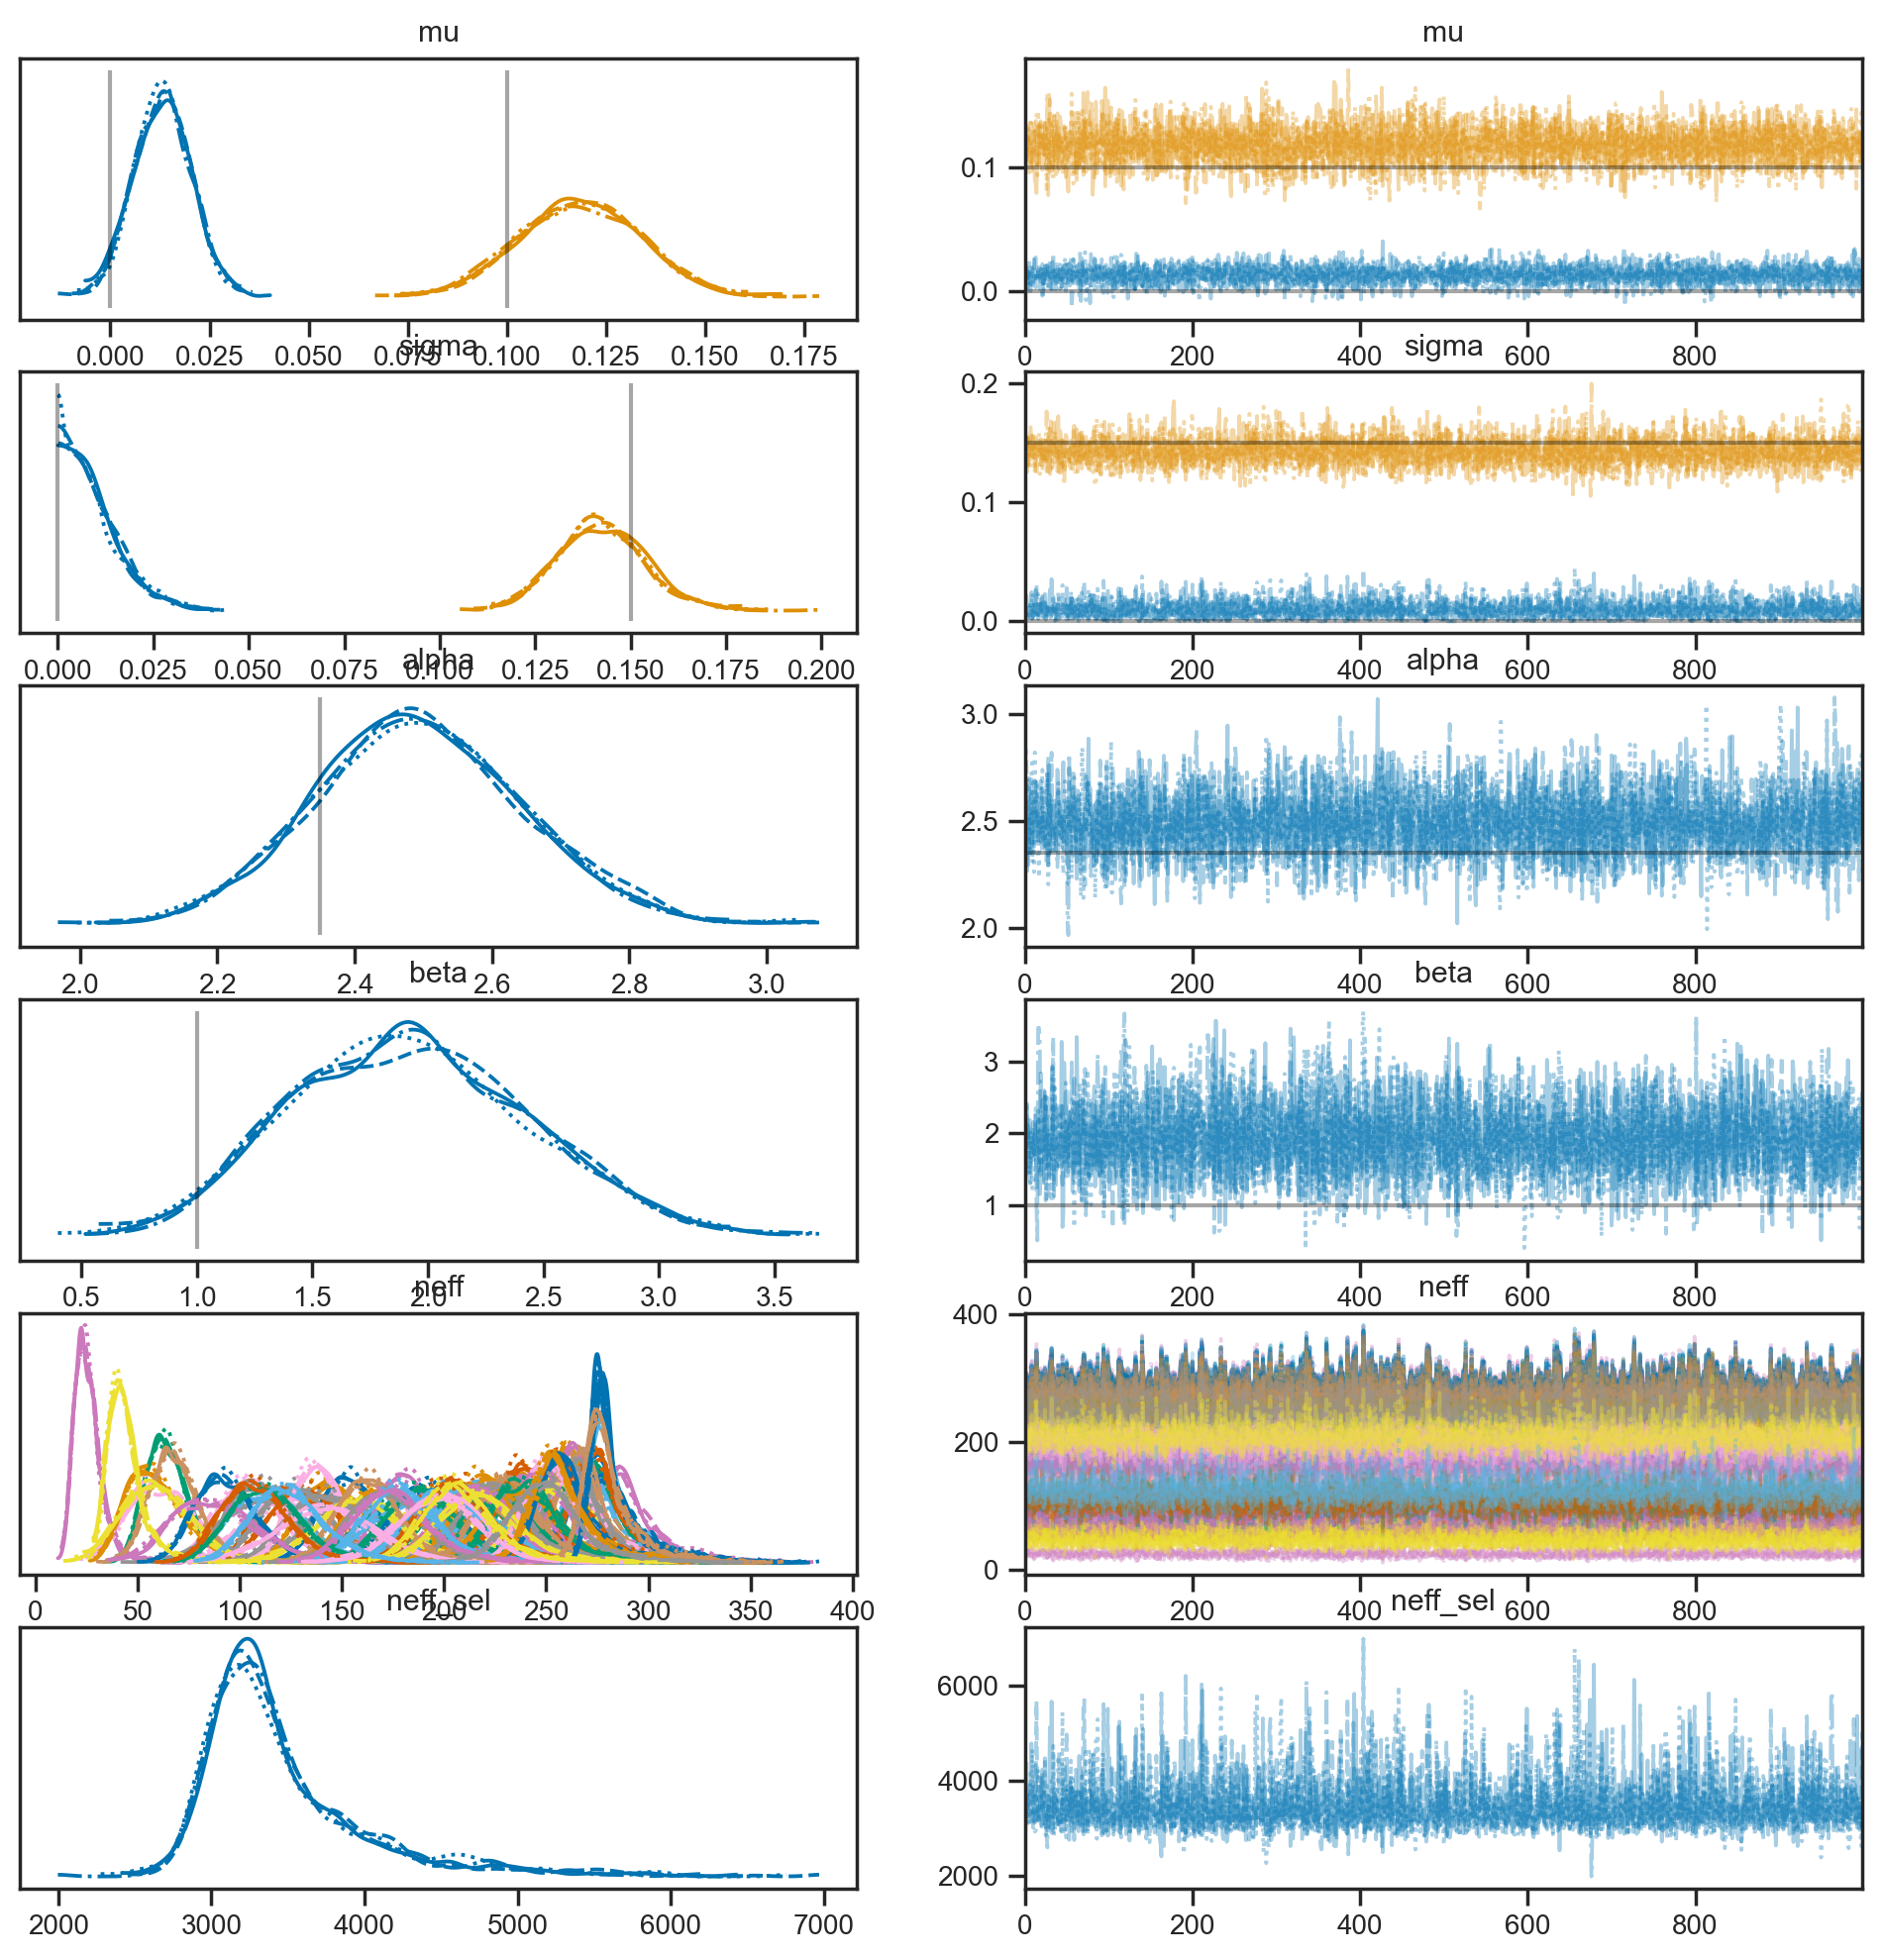

In [39]:
az.plot_trace(trace, var_names=['mu', 'sigma', 'alpha', 'beta', 'neff', 'neff_sel'], lines=[('mu', {}, np.array([0.0, chi_mu])), ('sigma', {}, np.array([0.0, chi_sigma])), 
                                                                                            ('alpha', {}, alpha_true), ('beta', {}, beta_true)])

In [40]:
trace.posterior.neff.min(), trace.posterior.neff_sel.min()

(<xarray.DataArray 'neff' ()>
 array(10.8371586),
 <xarray.DataArray 'neff_sel' ()>
 array(1994.23054211))

In [41]:
pred = Predictive(full_model, mcmc.get_samples())
pred = pred(jax.random.PRNGKey(np.random.randint(1<<32)), marg_model, samples, normal_wts*other_wts, nnormal, predictive=True, samples_sel=samples_sel, pdraw_sel=pdraw_sel, n_draw_sel=ndraw_sel)

In [42]:
a_pred = pred['theta']

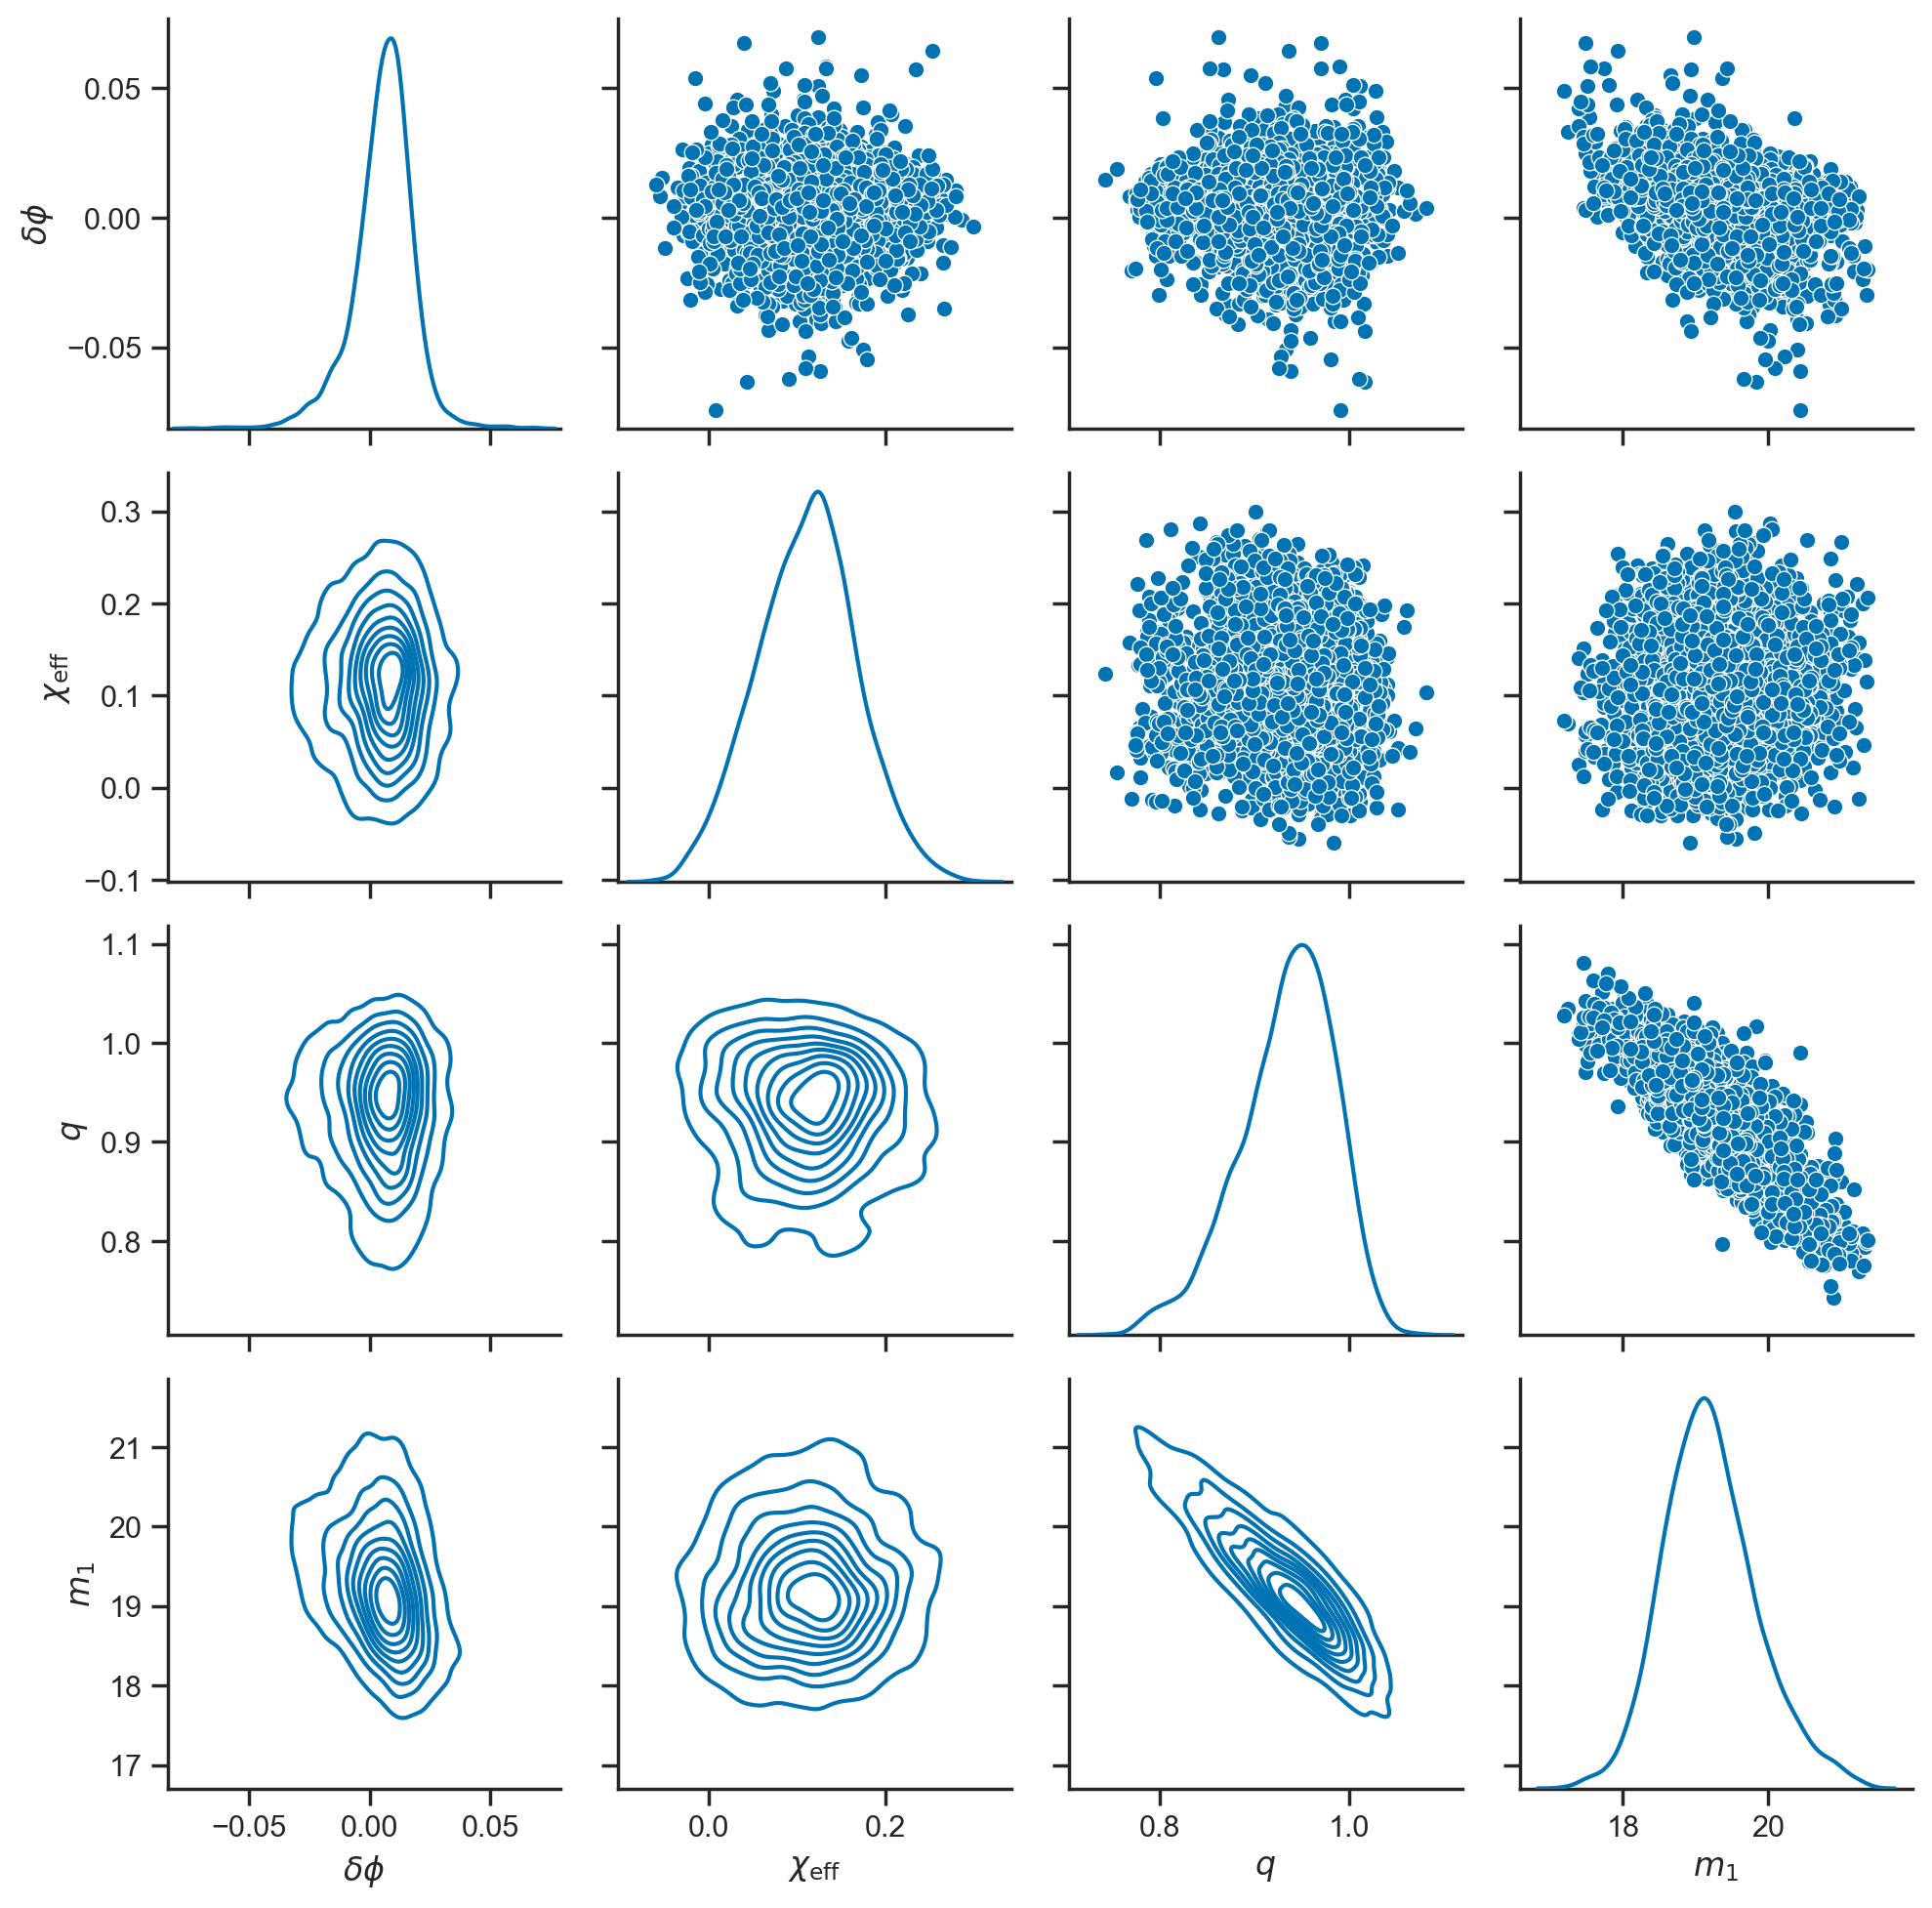

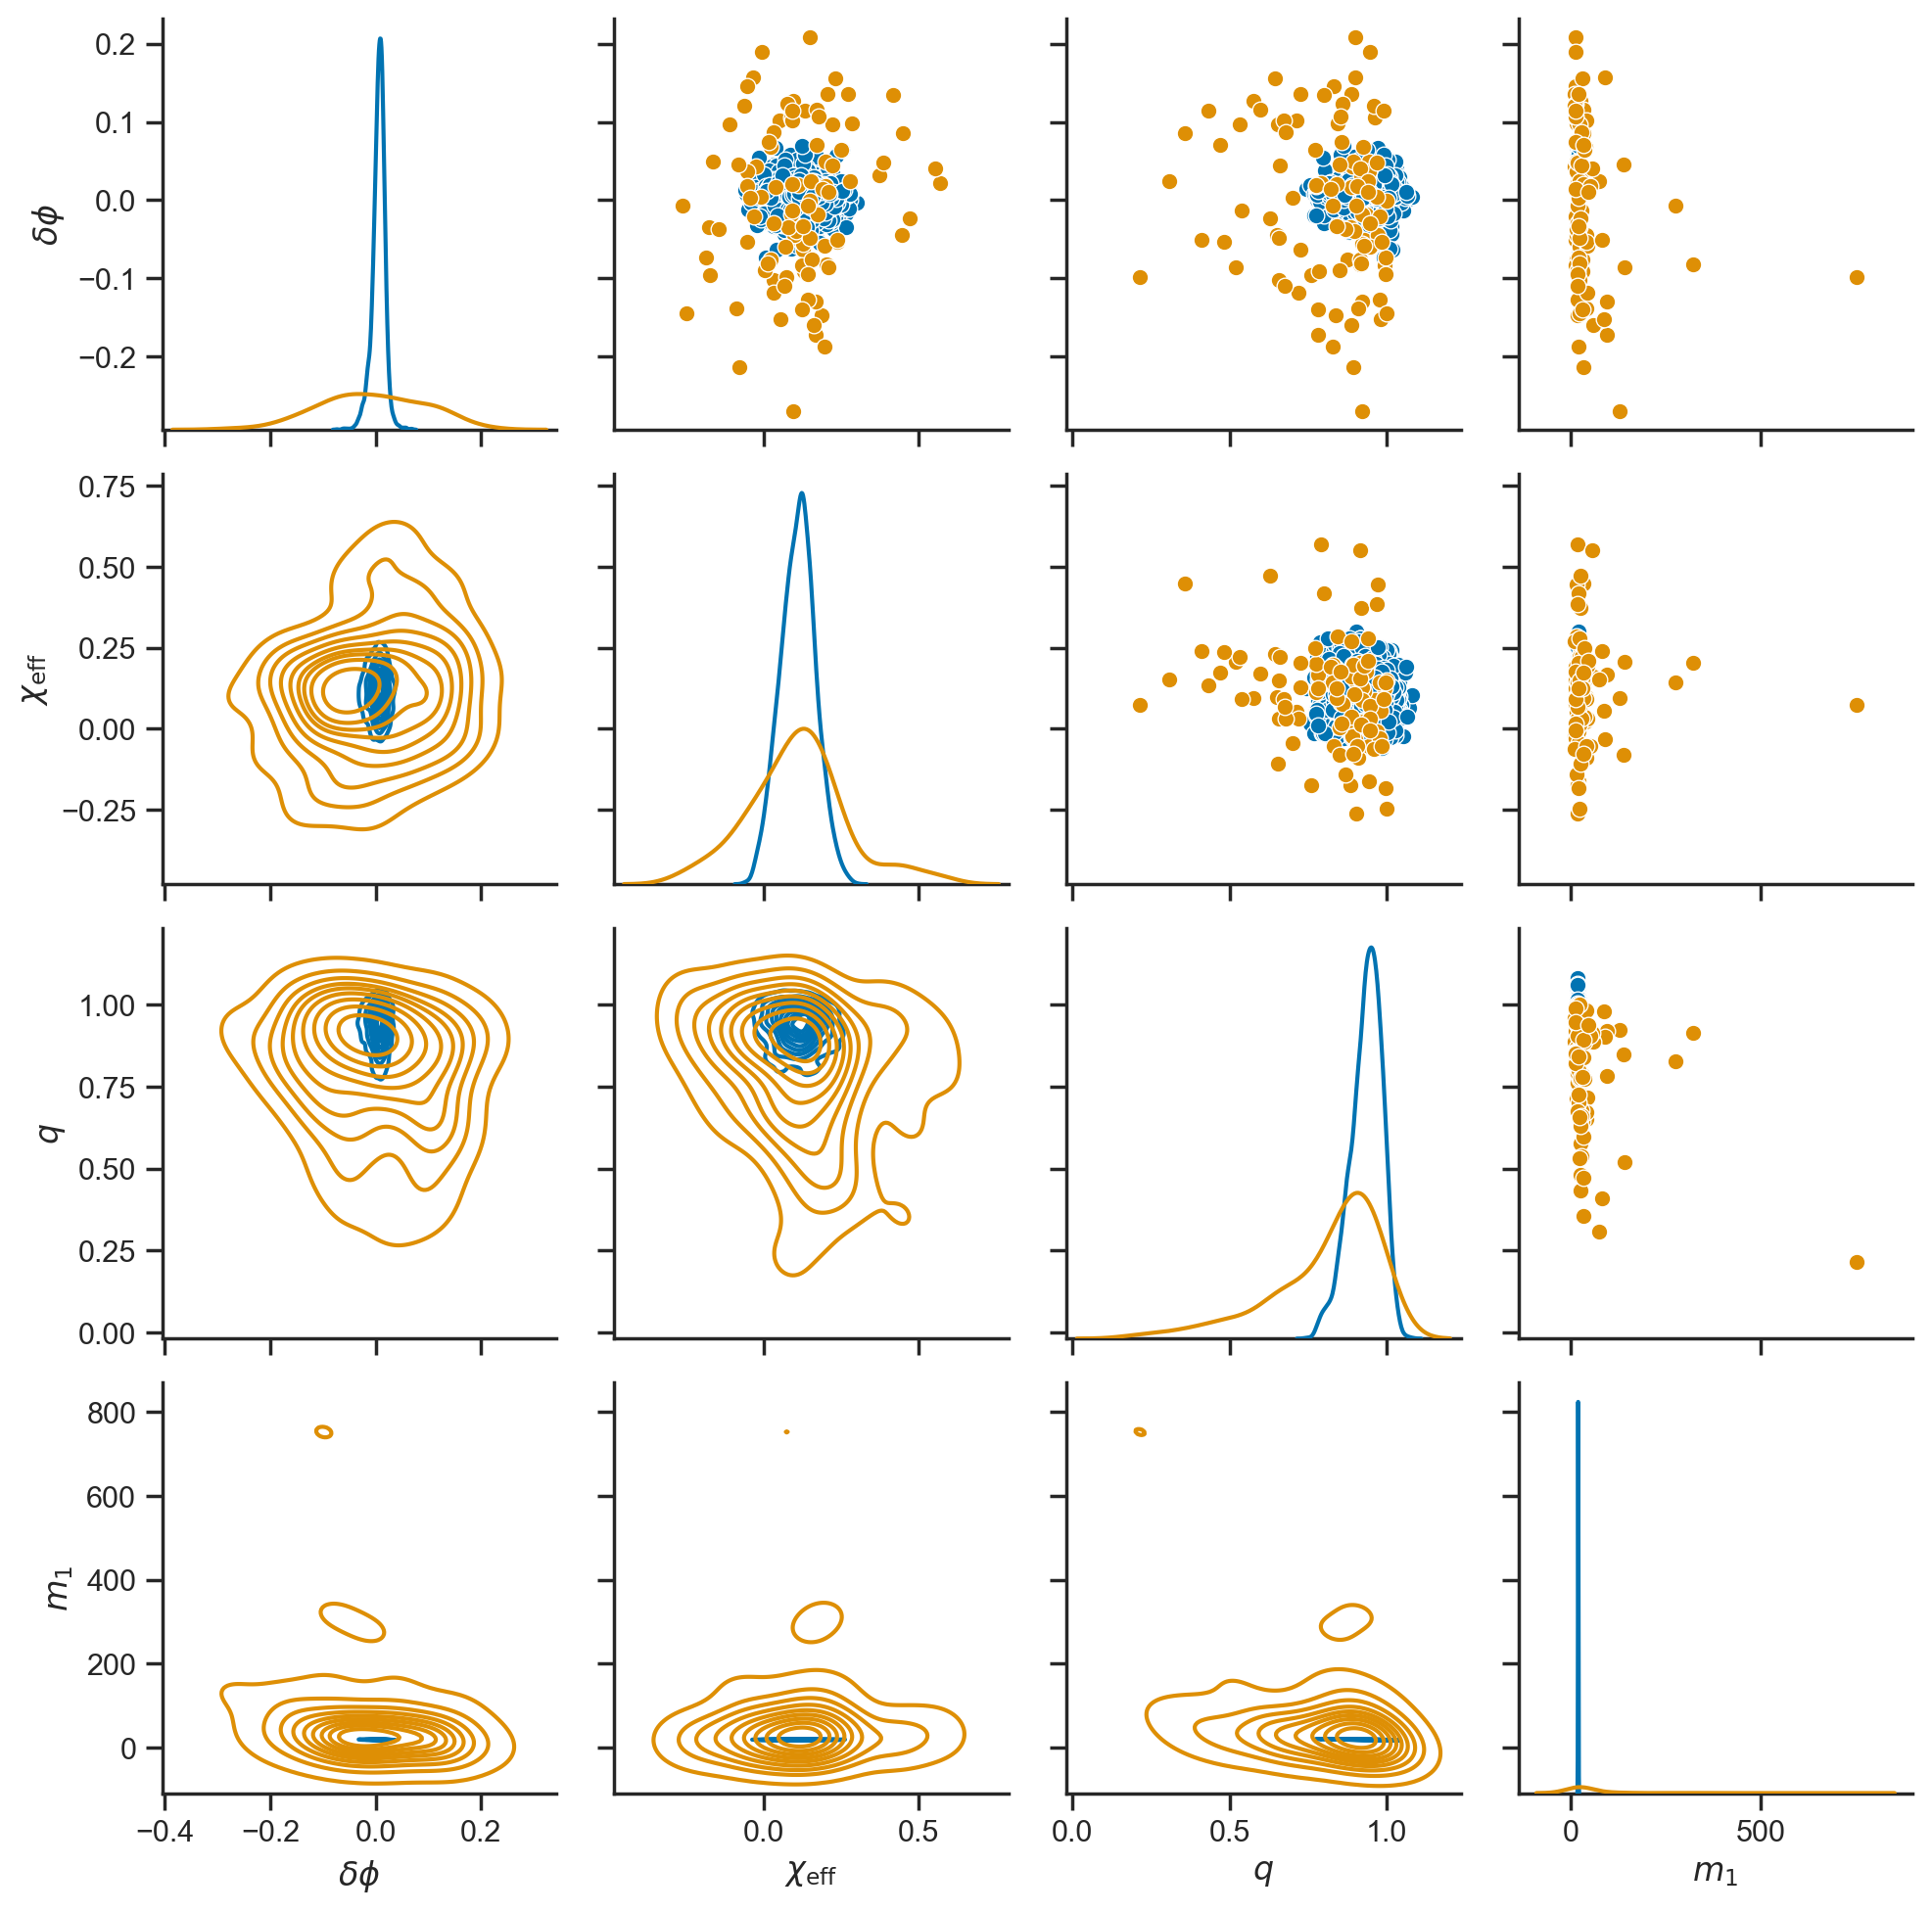

In [43]:
i = np.random.randint(nobs)
df = pd.DataFrame(a_pred[:,i,:], columns=[r'$\delta\phi$', r'$\chi_\mathrm{eff}$', r'$q$', r'$m_1$'])
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

df = pd.DataFrame(samples[:,i,:], columns=[r'$\delta\phi$', r'$\chi_\mathrm{eff}$', r'$q$', r'$m_1$'])
pg.data = df
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

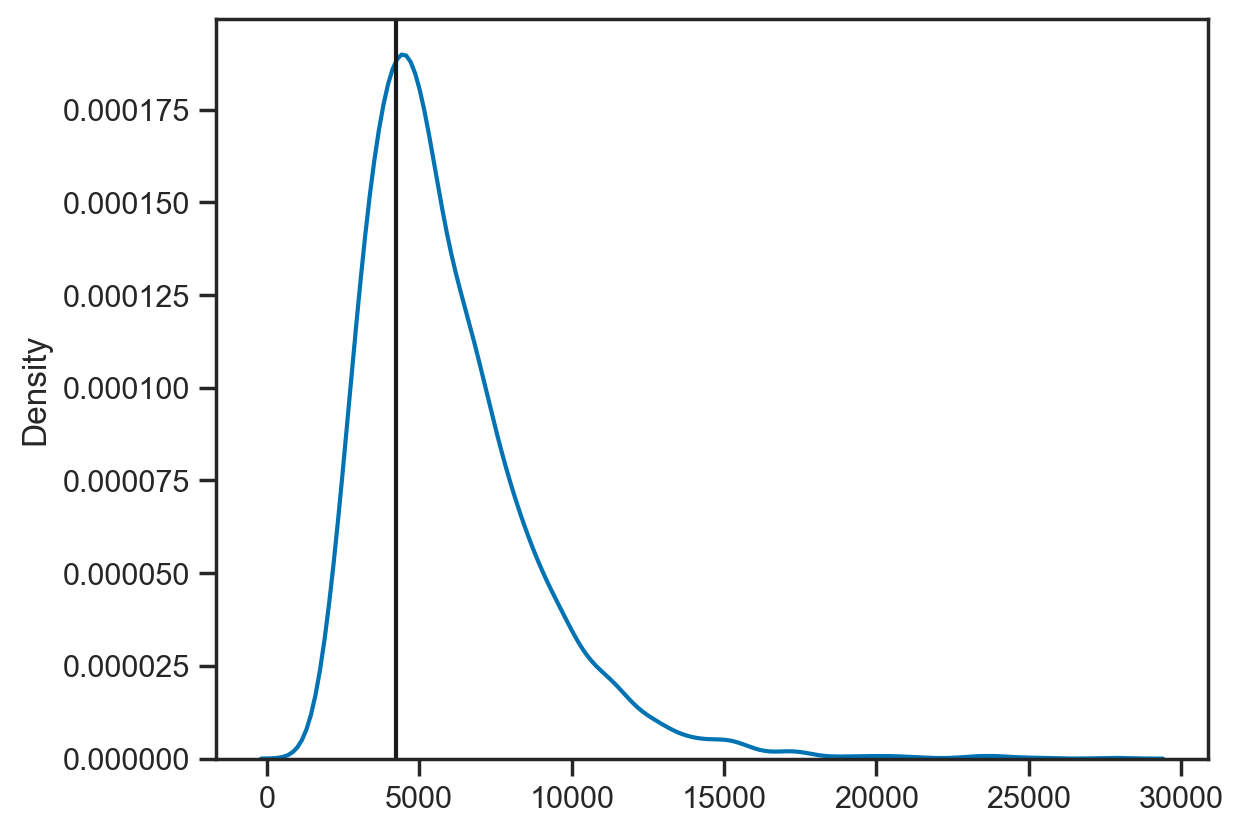

In [44]:
sns.kdeplot(pred['R'])
plt.axvline(R_true, color='k')

Text(0.5, 0, '$\\delta \\phi$')

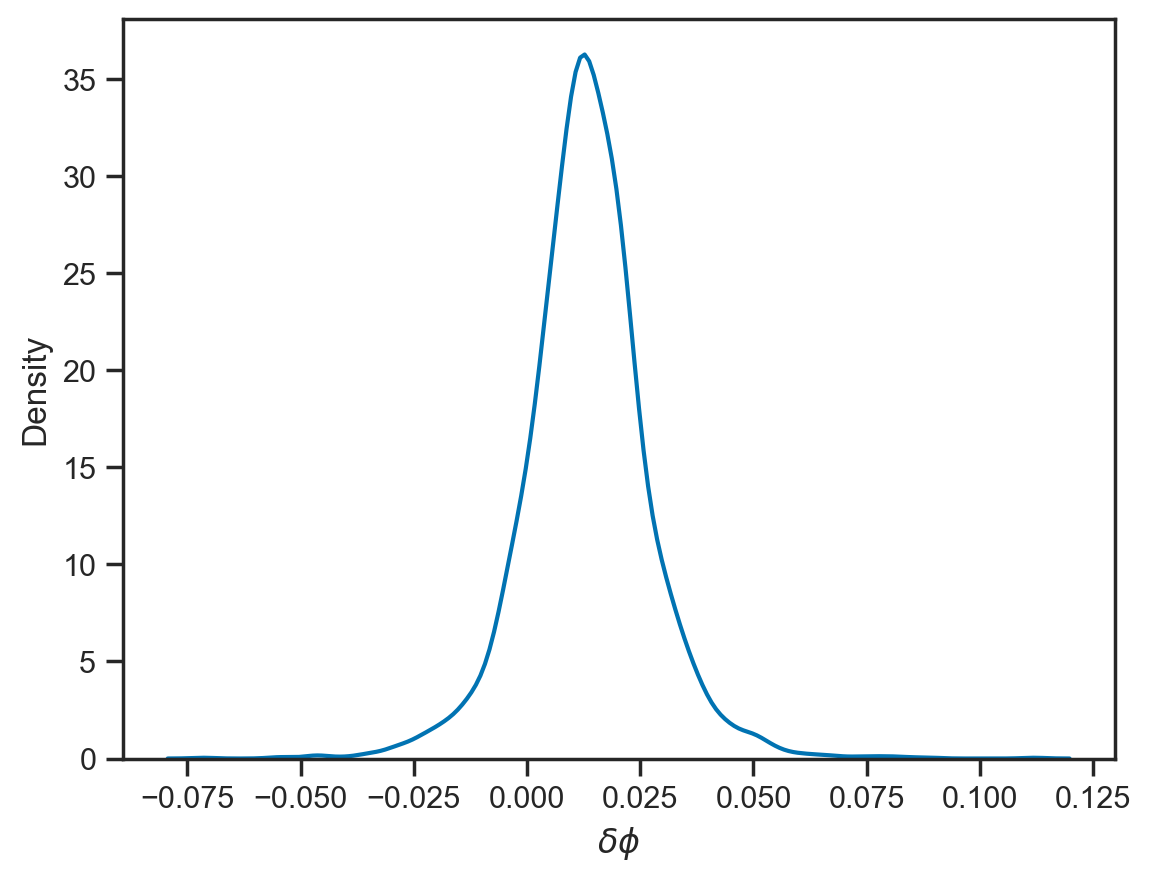

In [45]:
sns.kdeplot(pred['theta_gaussian_draw'][:,0])
plt.xlabel(r'$\delta \phi$')

Text(0.5, 0, '$\\chi_\\mathrm{eff}$')

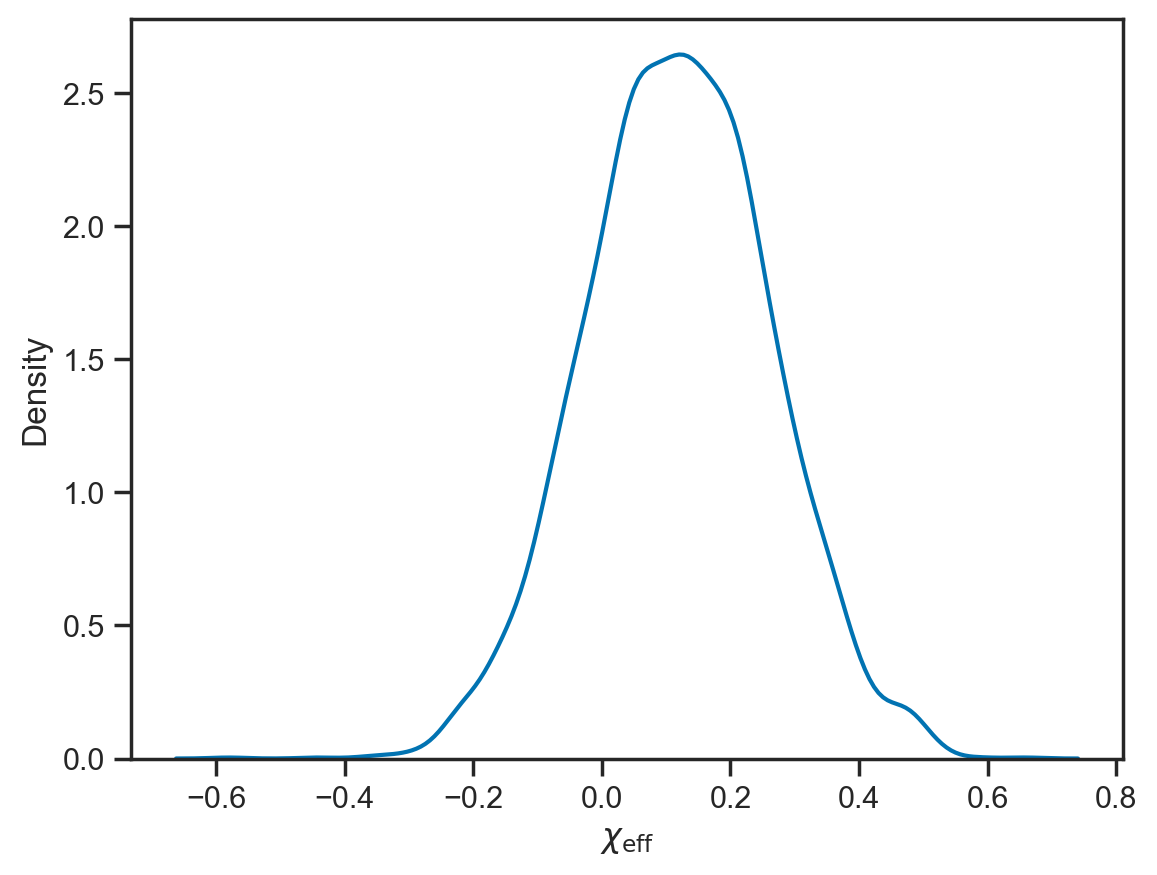

In [46]:
sns.kdeplot(pred['theta_gaussian_draw'][:,1])
plt.xlabel(r'$\chi_\mathrm{eff}$')

Text(0.5, 0, '$m_1$')

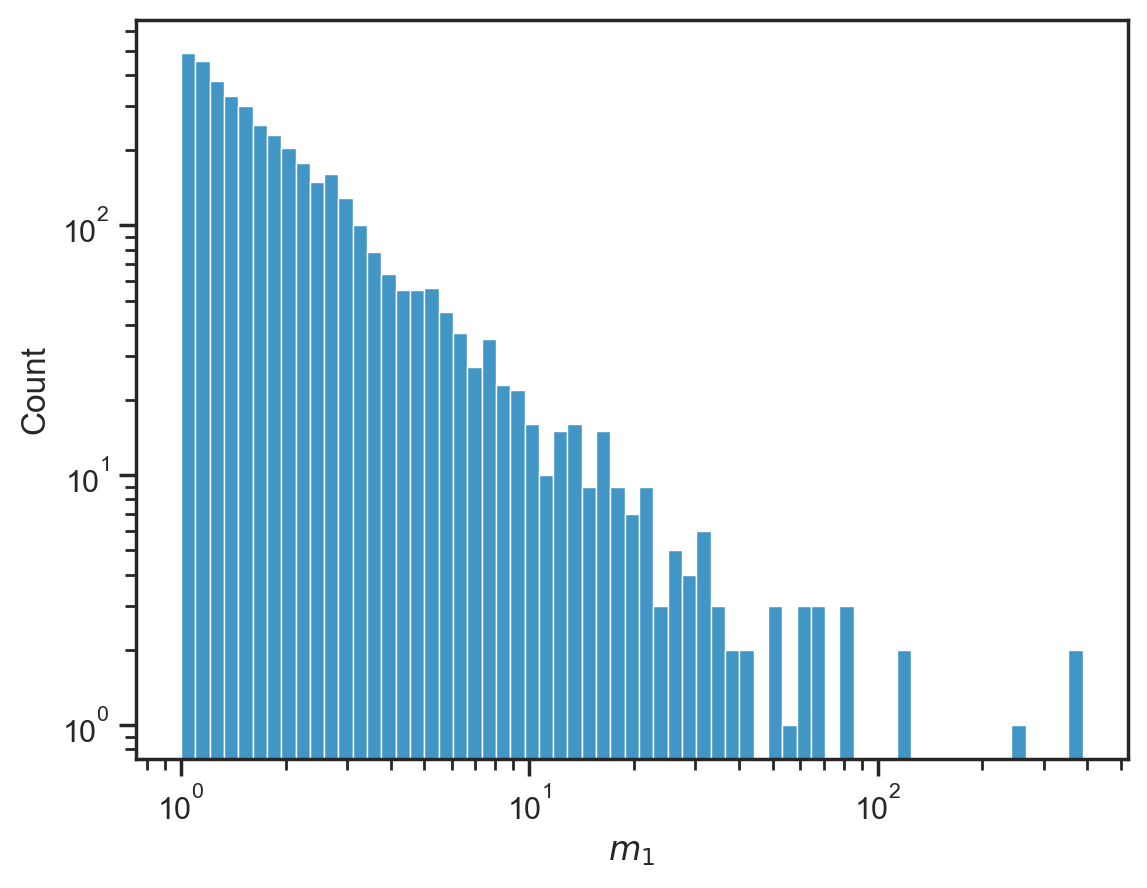

In [47]:
sns.histplot(pred['m1'], log_scale=True)
plt.yscale('log')
plt.xlabel('$m_1$')